In [1]:
!pip install imbalanced-learn==0.11.0 scikit-learn==1.3.0



In [2]:
import sklearn
import imblearn
print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)


scikit-learn version: 1.3.0
imbalanced-learn version: 0.11.0


Dataset Shape: (100000, 9)
Features shape: (100000, 13)
Target shape: (100000,)
Target class distribution:
 diabetes
0    91500
1     8500
Name: count, dtype: int64
Before SMOTE: (100000, 13) (100000,)
After SMOTE: (183000, 13) (183000,)

🔹 Training Logistic Regression...
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     18293
           1       0.91      0.92      0.92     18307

    accuracy                           0.92     36600
   macro avg       0.92      0.92      0.92     36600
weighted avg       0.92      0.92      0.92     36600

ROC-AUC: 0.9152

🔹 Training Random Forest...
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18293
           1       0.98      0.97      0.98     18307

    accuracy                           0.98     36600
   macro avg       0.98      0.98      0.98     36600
weighted avg       0.98      0.98      0.98     36600

ROC-AUC: 0.9769

🔹 Training 

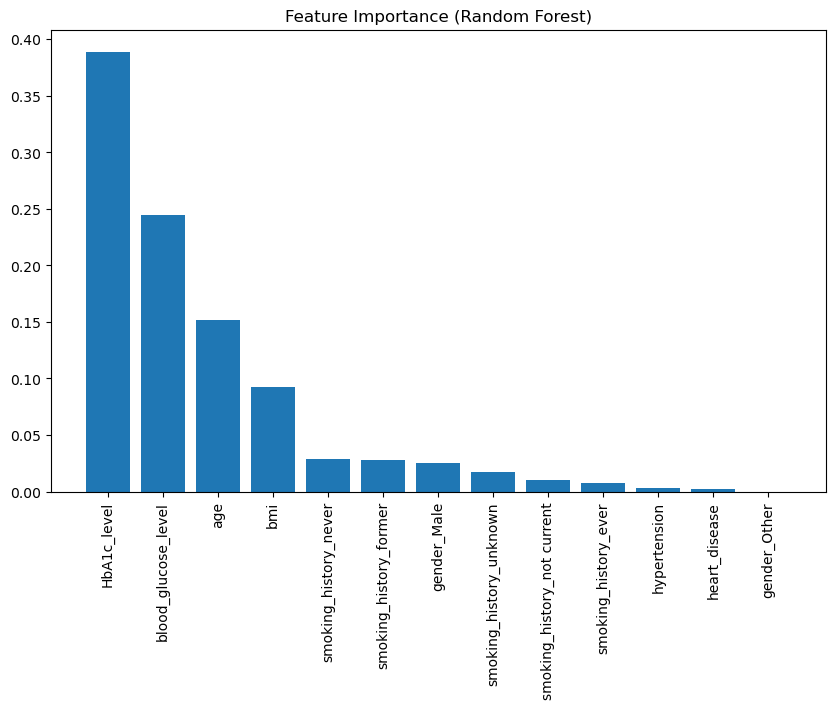

🔍 Prediction: Not Diabetic
📊 Probability of Diabetes: 0.0 %


In [3]:
# ========================
# 1. Load Data from IBM COS
# ========================
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt
import numpy as np

def __iter__(self): return 0

# @hidden_cell - your credentials here
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Qgdra7aXtvZ6q7TuacYOuwUDzvmJFPp8vgOkVkqZdzqF', 
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.jp-tok.cloud-object-storage.appdomain.cloud')

bucket = 'diabetesprediction-donotdelete-pr-358woytu5yy628'
object_key = 'Diebatic.csv'

body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType(__iter__, body)

df = pd.read_csv(body)
print("Dataset Shape:", df.shape)
df.head()

# ========================
# 2. Data Preprocessing
# ========================

# Replace "No Info" with "unknown"
df['smoking_history'] = df['smoking_history'].replace("No Info", "unknown")

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

# Features & target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Target class distribution:\n", y.value_counts())

# ========================
# 3. Handle Class Imbalance (SMOTE)
# ========================
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Before SMOTE:", X.shape, y.shape)
print("After SMOTE:", X_resampled.shape, y_resampled.shape)

# ========================
# 4. Train-Test Split
# ========================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# ========================
# 5. Train Models
# ========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Classification report
    print(classification_report(y_test, y_pred))

    # ROC-AUC score
    auc = roc_auc_score(y_test, y_pred)
    results[name] = auc
    print(f"ROC-AUC: {auc:.4f}")

# ========================
# 6. Compare Models
# ========================
print("\n📊 Model Comparison (ROC-AUC):")
for model, auc in results.items():
    print(f"{model}: {auc:.4f}")

    # ========================
# 7. Evaluate Best Model (Random Forest)
# ========================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Get predictions
y_pred = models["Random Forest"].predict(X_test)

# Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nROC-AUC Score:", roc_auc)


# ========================
# 8. Evaluate Best Model using matplotlib and numpy (Random Forest)
# ========================

# Get feature importance
importances = models["Random Forest"].feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.show()

# ========================
# 9. Predict for Single User Input
# ========================
# Example user input
user_data = {
    "gender": "male",             # male/female/other
    "age": 45,
    "hypertension": 1,            # 0 = No, 1 = Yes
    "heart_disease": 0,           # 0 = No, 1 = Yes
    "smoking_history": "never", # never, former, current, unknown
    "bmi": 20,
    "HbA1c_level": 5.2,
    "blood_glucose_level": 120
}

# Convert into DataFrame (single row)
user_df = pd.DataFrame([user_data])

# Preprocess same as training data
user_df['smoking_history'] = user_df['smoking_history'].replace("No Info", "unknown")
user_df = pd.get_dummies(user_df, columns=['gender', 'smoking_history'], drop_first=True)

# Align columns with training data
user_df = user_df.reindex(columns=X_train.columns, fill_value=0)

# Predict probability
prob = models["Random Forest"].predict_proba(user_df)[:,1][0]
prediction = models["Random Forest"].predict(user_df)[0]
print("🔍 Prediction:", "Diabetic" if prediction==1 else "Not Diabetic")
print("📊 Probability of Diabetes:", round(prob*100, 2), "%")




Dataset Shape: (100000, 9)
Features shape: (100000, 16)
Target shape: (100000,)
Target class distribution:
 diabetes
0    91500
1     8500
Name: count, dtype: int64
Before SMOTE: (100000, 16) (100000,)
After SMOTE: (183000, 16) (183000,)

🔹 Tuning Random Forest...
✅ Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': True}
✅ Best CV ROC-AUC: 0.9973599133964701


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



🔹 Training Ensemble Model...
✅ Model and feature list saved successfully!

🔹 5-Fold CV (Random Forest)...
RF CV ROC-AUC Scores: [0.99241208 0.9990264  0.99910151 0.99896565 0.99891443]
Average RF CV ROC-AUC: 0.9976840141539013

🔹 5-Fold CV (Ensemble)...


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ensemble CV ROC-AUC Scores: [0.98769378 0.99875622 0.99898408 0.9986982  0.9987315 ]
Average Ensemble CV ROC-AUC: 0.996572756726089

🔹 Evaluating Logistic Regression...
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     18293
           1       0.88      0.86      0.87     18307

    accuracy                           0.87     36600
   macro avg       0.87      0.87      0.87     36600
weighted avg       0.87      0.87      0.87     36600

ROC-AUC: 0.8701

🔹 Evaluating Random Forest...
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18293
           1       0.98      0.97      0.98     18307

    accuracy                           0.98     36600
   macro avg       0.98      0.98      0.98     36600
weighted avg       0.98      0.98      0.98     36600

ROC-AUC: 0.9763

🔹 Evaluating XGBoost...
              precision    recall  f1-score   support

           0       0.96      0.99 

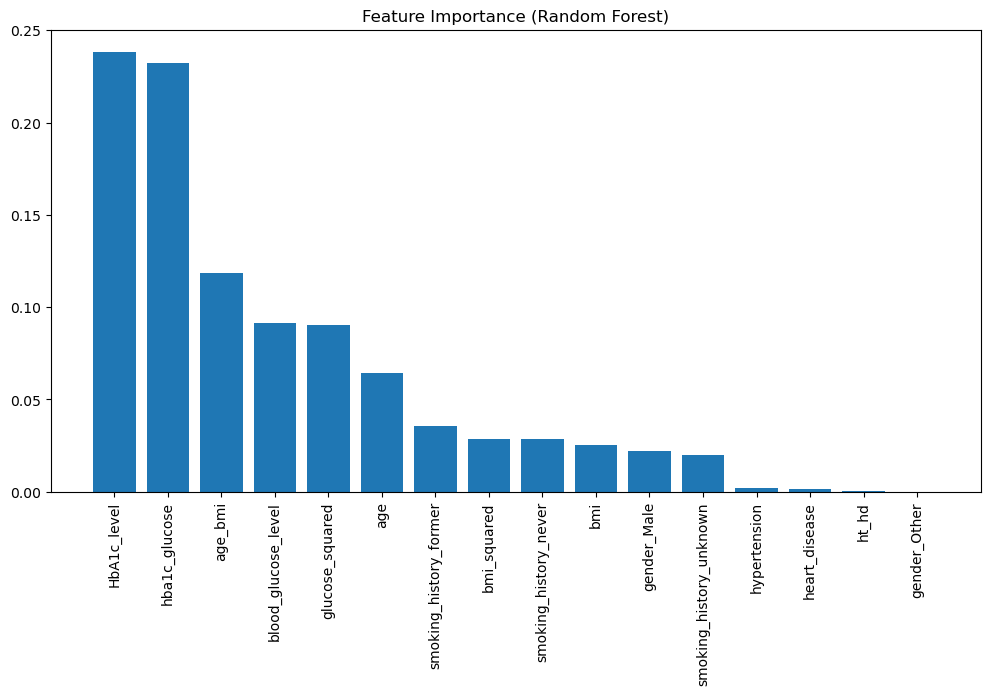


🔍 Single User Prediction (Random Forest): Not Diabetic
📊 Probability (RF): 24.59 %

🔍 Single User Prediction (Ensemble): Not Diabetic
📊 Probability (Ensemble): 29.83 %


In [4]:
# ========================
# 1. Load Data from IBM COS
# ========================
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt
import numpy as np

def __iter__(self): return 0

# @hidden_cell - your credentials here
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Qgdra7aXtvZ6q7TuacYOuwUDzvmJFPp8vgOkVkqZdzqF', 
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.jp-tok.cloud-object-storage.appdomain.cloud')

bucket = 'diabetesprediction-donotdelete-pr-358woytu5yy628'
object_key = 'Diebatic.csv'

body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType(__iter__, body)

df = pd.read_csv(body)
print("Dataset Shape:", df.shape)
df.head()

# ========================
# 2. Data Preprocessing + Feature Engineering
# ========================
# Replace "No Info" with "unknown"
df['smoking_history'] = df['smoking_history'].replace("No Info", "unknown")

# --- Feature Engineering ---
df['age_bmi'] = df['age'] * df['bmi']
df['hba1c_glucose'] = df['HbA1c_level'] * df['blood_glucose_level']
df['ht_hd'] = df['hypertension'] * df['heart_disease']
df['bmi_squared'] = df['bmi'] ** 2
df['glucose_squared'] = df['blood_glucose_level'] ** 2

# Merge rare categories
df['smoking_history'] = df['smoking_history'].replace({'ever': 'former', 'not current': 'former'})

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

# Features & target
X = df.drop('diabetes', axis=1)
y = df['diabetes']
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Target class distribution:\n", y.value_counts())


# ========================
# 3. Handle Class Imbalance (SMOTE)
# ========================
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Before SMOTE:", X.shape, y.shape)
print("After SMOTE:", X_resampled.shape, y_resampled.shape)

# ========================
# 4. Train-Test Split
# ========================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


   
    
# ========================
# 5–7. Train Models + Overfitting Control + Ensemble + CV
# ========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# --- Random Forest Hyperparameter Tuning (Overfitting Control) ---
param_grid = {
    'n_estimators': [200, 500, 800],        # Number of trees
    'max_depth': [10, 20, 30],              # Limit tree depth
    'min_samples_split': [5, 10],           # Min samples to split
    'min_samples_leaf': [2, 4],             # Min samples per leaf
    'max_features': ['sqrt', 'log2'],       # Random feature selection
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

print("\n🔹 Tuning Random Forest...")
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print("✅ Best Parameters:", rf_random.best_params_)
print("✅ Best CV ROC-AUC:", rf_random.best_score_)

# --- XGBoost with Overfitting Control ---
xgb_model = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=False)

# --- Logistic Regression (Properly Fitted) ---
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# --- Ensemble Model (Voting Classifier) ---
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', best_rf),
        ('xgb', xgb_model)
    ],
    voting='soft'
)
print("\n🔹 Training Ensemble Model...")
ensemble_model.fit(X_train, y_train)

# ========================
# 11. Save Model + Features for Deployment
# ========================
import joblib

# Save the best performing model (you can pick ensemble_model or best_rf)
joblib.dump(ensemble_model, "diabetes_model.pkl")

# Save the feature order (needed when preprocessing new user input)
joblib.dump(X_train.columns, "model_features.pkl")

print("✅ Model and feature list saved successfully!")


# --- Models Dictionary for Evaluation ---
models = {
    "Logistic Regression": lr_model,
    "Random Forest": best_rf,
    "XGBoost": xgb_model,
    "Ensemble (Voting)": ensemble_model
}

# --- Cross-Validation Evaluation ---
print("\n🔹 5-Fold CV (Random Forest)...")
rf_cv_scores = cross_val_score(best_rf, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("RF CV ROC-AUC Scores:", rf_cv_scores)
print("Average RF CV ROC-AUC:", np.mean(rf_cv_scores))

print("\n🔹 5-Fold CV (Ensemble)...")
ensemble_cv_scores = cross_val_score(ensemble_model, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("Ensemble CV ROC-AUC Scores:", ensemble_cv_scores)
print("Average Ensemble CV ROC-AUC:", np.mean(ensemble_cv_scores))

# --- Evaluate All Models on Test Set ---
results = {}
for name, model in models.items():
    print(f"\n🔹 Evaluating {name}...")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_pred)
    results[name] = auc
    print(f"ROC-AUC: {auc:.4f}")

print("\n📊 Model Comparison (ROC-AUC):")
for model_name, auc in results.items():
    print(f"{model_name}: {auc:.4f}")

    

  



  # ========================
# 6. Cross-Validation Evaluation
# ========================
from sklearn.model_selection import cross_val_score
import numpy as np

print("\n🔹 Cross-Validation (Random Forest)...")
rf_cv_scores = cross_val_score(best_rf, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("RF CV ROC-AUC Scores:", rf_cv_scores)
print("Average RF CV ROC-AUC:", np.mean(rf_cv_scores))

print("\n🔹 Cross-Validation (Ensemble)...")
ensemble_cv_scores = cross_val_score(ensemble_model, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
print("Ensemble CV ROC-AUC Scores:", ensemble_cv_scores)
print("Average Ensemble CV ROC-AUC:", np.mean(ensemble_cv_scores))


# ========================
# 9. Feature Importance (Random Forest)
# ========================
importances = best_rf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.show()

# ========================
# 10. Predict for Single User Input
# ========================
user_data = {
    "gender": "male",
    "age": 45,
    "hypertension": 1,
    "heart_disease": 0,
    "smoking_history": "never",
    "bmi": 30.9,
    "HbA1c_level": 6.2,
    "blood_glucose_level": 180
}

user_df = pd.DataFrame([user_data])

# Feature Engineering for user input
user_df['age_bmi'] = user_df['age'] * user_df['bmi']
user_df['hba1c_glucose'] = user_df['HbA1c_level'] * user_df['blood_glucose_level']
user_df['ht_hd'] = user_df['hypertension'] * user_df['heart_disease']
user_df['bmi_squared'] = user_df['bmi'] ** 2
user_df['glucose_squared'] = user_df['blood_glucose_level'] ** 2

user_df['smoking_history'] = user_df['smoking_history'].replace({'No Info': 'unknown', 'ever': 'former', 'not current': 'former'})
user_df = pd.get_dummies(user_df, columns=['gender','smoking_history'], drop_first=True)
user_df = user_df.reindex(columns=X_train.columns, fill_value=0)

# Predict using Tuned Random Forest
prob_rf = best_rf.predict_proba(user_df)[:,1][0]
pred_rf = best_rf.predict(user_df)[0]

# Predict using Ensemble
prob_ens = ensemble_model.predict_proba(user_df)[:,1][0]
pred_ens = ensemble_model.predict(user_df)[0]

print("\n🔍 Single User Prediction (Random Forest):", "Diabetic" if pred_rf==1 else "Not Diabetic")
print("📊 Probability (RF):", round(prob_rf*100,2), "%")
print("\n🔍 Single User Prediction (Ensemble):", "Diabetic" if pred_ens==1 else "Not Diabetic")
print("📊 Probability (Ensemble):", round(prob_ens*100,2), "%")


